In [278]:
from math import sqrt
from datetime import datetime, timedelta

# for scaling and inverse_transform
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from pandas import read_csv
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates


## 1. Read the raw csv data

In [2]:
cols=['id', 'created_at', 'destroyed_at']
server_data = pd.read_csv("servers.csv", delimiter=",", names=cols, header=None )

In [3]:
cols=['timestamp', 'device_id', 'user_id','server_id', 'connected']
dtypes = {'timestamp': 'str', 'device_id': 'int', 'user_id': 'int', 'server_id': 'int', 'connected':'bool'}
parse_dates = ['timestamp']
events_data = pd.read_csv("connectivity_events.csv", delimiter=",", names=cols, header=None,dtype=dtypes, parse_dates=parse_dates )

In [4]:
events_data.shape

(9308207, 5)

In [5]:
events_data.columns

Index(['timestamp', 'device_id', 'user_id', 'server_id', 'connected'], dtype='object')

In [149]:
events_data.dtypes

timestamp    datetime64[ns]
device_id             int64
user_id               int64
server_id             int64
connected              bool
dtype: object

## 2. Fill and process the device event stream data 

In [6]:
# start, end takes pandas.Timestamp
def fillDates(start, end):
    #print("fillDates", type(start), start, type(end),end)
    dates = list()
    for i in  range(1,(end.date() - start.date()).days):
        oneday = pd.Timedelta('%d days'%i)
        dates.append(start + oneday)
    return dates

In [7]:
def processEventStream(row):
    r = list()
    dates = list()
    #print(row)

    try:
        if (device_state[row[1]]):
            #print("device details exist")
            #print(row)
            timestamp = row [0]
            device_id = row [1]
            user_id = row [2]
            server_id = row [3]
            next_event = row [4]
            
            if device_state[row[1]]["state"]: # current event 'online'
                if next_event: # next event 'online'
                    if device_state[row[1]]["server"] == server_id: # case 1
                        # Assume device was online from current event's timestamp until next event's timestamp
                        dates = fillDates(device_state[row[1]]["timestamp"], timestamp)
                    else: # case 2 different server
                        # get previous server destruction time
                        destruction_time = pd.Timestamp(server_data[server_data['id'] == 2]['destroyed_at'].values[0])
                        if (pd.Timestamp(destruction_time) < timestamp):
                            dates = fillDates(device_state[row[1]]["timestamp"], destruction_time)
                        else:
                            dates = fillDates(device_state[row[1]]["timestamp"], timestamp)
                    
                    #update the state dictionary Case 1 & 2
                    state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                    device_state[device_id] = state_dict        
                else:# next event 'offline', 
                    if device_state[row[1]]["server"] == server_id: # case 3 Normal case, same next server
                        #update the state dictionary Case 3
                        state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                        device_state[device_id] = state_dict
                    else:# case 4, different next server
                        # get previous server destruction time
                        destruction_time = pd.Timestamp(server_data[server_data['id'] == 2]['destroyed_at'].values[0])
                        dates = fillDates(device_state[row[1]]["timestamp"], destruction_time)
                        # *NO* update for the state dictionary in Case 4
            else:  # current event 'offline'
                if next_event: # next event 'online' # case 5 & case 6: Normal Case
                        #update the state dictionary: case 5 & 6
                        state_dict = {"state": next_event, "server":server_id, "timestamp":timestamp}
                        device_state[device_id] = state_dict
                        dates = list().append(timestamp)
                else: # next event 'offline' # case 7 &  case 8
                        pass # Ignore next event
                
            if dates:
                for d in dates:
                    newentry = list()
                    newentry.append(d)
                    newentry.append(device_id)
                    newentry.append(user_id)
                    #print(newentry)
                    rows_list.append(newentry)
                #print("more dates", dates)
            
    except KeyError:
        state_dict = {"state":row[4], "server":row[3], "timestamp":row[0]}
        device_state[row[1]] = state_dict
        #print(row[1], device_state[row[1]])
        if (row[4]):
            r = row.tolist()
            #print("r",type(r))
            rows_list.append(r[0:3]) 

    return r


In [306]:
device_state = dict()
rows_list = list()
#print( device_state)
#df = small_data.apply(processEventStream, axis=1)
events_data=events_data.apply(processEventStream, axis=1)

## 3. Calculate daily unique number of devices connected

In [11]:
events_data_connected =  pd.DataFrame(rows_list)
events_data_connected.columns = ["timestamp", "device_id", "user_id"]

In [305]:
events_data_connected=events_data_connected.dropna()

In [17]:
events_data_connected['date'] = pd.DatetimeIndex(events_data_connected['timestamp']).date

In [19]:
unique_device_per_day = events_data_connected.drop_duplicates(["date", "device_id"],keep = "first")

In [23]:
#dev_count_perday_peruser = unique_device_per_day.groupby(['date', 'user_id']).agg({'device_id':["count"]})

In [24]:
#dev_count_perday_peruser.columns

In [25]:
#dev_count_perday_peruser

In [28]:
dev_count_perday = unique_device_per_day.groupby(['date'])['device_id'].count().reset_index(name='count')

## 4. Save data as csv

In [151]:
dev_count_perday['date'] = dev_count_perday['date'].astype('datetime64[ns]')
dev_count_perday.to_csv("data.csv")

In [168]:
test_data = dev_count_perday[(dev_count_perday["date"]) > pd.Timestamp('2017-02-28')]
test_data.to_csv("test_data.csv")

In [207]:
test_data_input = dev_count_perday[ (pd.Timestamp('2016-02-28') < dev_count_perday["date"])
                                  & (pd.Timestamp('2017-02-28') > dev_count_perday["date"])]
test_data_input.to_csv("test_data_input.csv") # 365 records

## 5. Scale and prepare Timeseries sequence

In [ ]:
# prepare time series data for supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	print(type(data))
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()

	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1): # range([start,] stop [, step])
        # DataFrame.shift(periods=1, freq=None, axis=0), returns DataFrame
		cols.append(df.shift(i)) 
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	# We are only interested in final bb after certain frames, e.g. 31st, 61st etc
	for i in range(n_out -1, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
    #  concatenating along the columns (axis=1), a DataFrame is returned.
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [253]:
count = dev_count_perday['count'].to_numpy()[0:800]
test_count = dev_count_perday['count'].to_numpy()[800:]

In [255]:
# specify the number of lag days
n_input_seq = 360
n_seq_future = 1
n_features = 1

In [256]:
# ensure all data is float
count = count.astype('float32').reshape(-1, 1)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(count.reshape(-1, 1))

In [258]:
# frame as supervised learning
reframed = series_to_supervised(scaled, n_input_seq, n_seq_future, False)

<class 'numpy.ndarray'>


## 6. Prepare training and validation data

In [114]:
# split into train and test sets
values = reframed.values
n_train_num = int(reframed.shape[0] * 0.8)
train = values[:n_train_num, :]
val = values[n_train_num:, :]

# split into input and outputs
n_obs = n_input_seq * n_features # In future it is expected to build the model with additional features
train_X, train_y = train[:, :n_obs], train[:, n_obs:n_obs+n_features]
val_X, val_y = val[:, :n_obs], val[:, n_obs:n_obs+n_features]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_input_seq, n_features))
val_X = val_X.reshape((val_X.shape[0], n_input_seq, n_features))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape)

(352, 360) 352 (352, 1)
(352, 360, 1) (352, 1) (88, 360, 1) (88, 1)


In [119]:
test_count[0]

135

## 7. Prepare the ML model

In [302]:
from keras import backend as K
from keras import optimizers

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, CSVLogger

In [92]:
# model callbacks.

# filepath under which the weights are saveed
model_checkpoint = ModelCheckpoint(filepath='epoch-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True,
                                   save_weights_only=False,
                                   mode='auto',
                                   period=1)

csv_logger = CSVLogger(filename='dev_count_lstm_training_log.csv',
                       separator=',',
                       append=True)
callbacks = [model_checkpoint,
             csv_logger
            ]


In [99]:
# design network
K.clear_session()  # Clear previous models from memory.    
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
#adam = optimizers.Adam(lr=0.01, decay=0.0001)
model.compile(loss='mae', optimizer="adam")
#A loss function or objective function: mean_absolute_error

epochs = 300
# fit network
history = model.fit(train_X, train_y, 
                    epochs=epochs, 
                    batch_size=16, 
                    validation_data=(val_X, val_y), 
                    verbose=2,
                    callbacks=callbacks,
                    shuffle=False)

Train on 352 samples, validate on 88 samples
Epoch 1/300
 - 18s - loss: 0.0649 - val_loss: 0.1504

Epoch 00001: val_loss improved from inf to 0.15038, saving model to epoch-01_loss-0.0649_val_loss-0.1504.h5
Epoch 2/300
 - 14s - loss: 0.0578 - val_loss: 0.1255

Epoch 00002: val_loss improved from 0.15038 to 0.12548, saving model to epoch-02_loss-0.0578_val_loss-0.1255.h5
Epoch 3/300
 - 14s - loss: 0.0601 - val_loss: 0.1248

Epoch 00003: val_loss improved from 0.12548 to 0.12479, saving model to epoch-03_loss-0.0601_val_loss-0.1248.h5
Epoch 4/300
 - 14s - loss: 0.0560 - val_loss: 0.1153

Epoch 00004: val_loss improved from 0.12479 to 0.11527, saving model to epoch-04_loss-0.0560_val_loss-0.1153.h5
Epoch 5/300
 - 14s - loss: 0.0552 - val_loss: 0.0958

Epoch 00005: val_loss improved from 0.11527 to 0.09579, saving model to epoch-05_loss-0.0552_val_loss-0.0958.h5
Epoch 6/300
 - 14s - loss: 0.0556 - val_loss: 0.0908

Epoch 00006: val_loss improved from 0.09579 to 0.09080, saving model to epo

 - 14s - loss: 0.0408 - val_loss: 0.0932

Epoch 00070: val_loss did not improve from 0.08242
Epoch 71/300
 - 15s - loss: 0.0409 - val_loss: 0.0899

Epoch 00071: val_loss did not improve from 0.08242
Epoch 72/300
 - 14s - loss: 0.0405 - val_loss: 0.0924

Epoch 00072: val_loss did not improve from 0.08242
Epoch 73/300
 - 14s - loss: 0.0405 - val_loss: 0.0897

Epoch 00073: val_loss did not improve from 0.08242
Epoch 74/300
 - 14s - loss: 0.0400 - val_loss: 0.0952

Epoch 00074: val_loss did not improve from 0.08242
Epoch 75/300
 - 14s - loss: 0.0405 - val_loss: 0.0864

Epoch 00075: val_loss did not improve from 0.08242
Epoch 76/300
 - 14s - loss: 0.0402 - val_loss: 0.1037

Epoch 00076: val_loss did not improve from 0.08242
Epoch 77/300
 - 14s - loss: 0.0405 - val_loss: 0.0970

Epoch 00077: val_loss did not improve from 0.08242
Epoch 78/300
 - 14s - loss: 0.0418 - val_loss: 0.0928

Epoch 00078: val_loss did not improve from 0.08242
Epoch 79/300
 - 14s - loss: 0.0409 - val_loss: 0.1101

Epoc

 - 14s - loss: 0.0394 - val_loss: 0.1003

Epoch 00147: val_loss did not improve from 0.08242
Epoch 148/300
 - 14s - loss: 0.0401 - val_loss: 0.1195

Epoch 00148: val_loss did not improve from 0.08242
Epoch 149/300
 - 14s - loss: 0.0391 - val_loss: 0.1004

Epoch 00149: val_loss did not improve from 0.08242
Epoch 150/300
 - 14s - loss: 0.0410 - val_loss: 0.0878

Epoch 00150: val_loss did not improve from 0.08242
Epoch 151/300
 - 14s - loss: 0.0390 - val_loss: 0.0926

Epoch 00151: val_loss did not improve from 0.08242
Epoch 152/300
 - 15s - loss: 0.0391 - val_loss: 0.0854

Epoch 00152: val_loss did not improve from 0.08242
Epoch 153/300
 - 14s - loss: 0.0390 - val_loss: 0.0947

Epoch 00153: val_loss did not improve from 0.08242
Epoch 154/300
 - 14s - loss: 0.0384 - val_loss: 0.0995

Epoch 00154: val_loss did not improve from 0.08242
Epoch 155/300
 - 14s - loss: 0.0382 - val_loss: 0.0995

Epoch 00155: val_loss did not improve from 0.08242
Epoch 156/300
 - 14s - loss: 0.0400 - val_loss: 0.0

 - 15s - loss: 0.0382 - val_loss: 0.0939

Epoch 00223: val_loss did not improve from 0.07978
Epoch 224/300
 - 15s - loss: 0.0365 - val_loss: 0.0976

Epoch 00224: val_loss did not improve from 0.07978
Epoch 225/300
 - 15s - loss: 0.0389 - val_loss: 0.0989

Epoch 00225: val_loss did not improve from 0.07978
Epoch 226/300
 - 15s - loss: 0.0381 - val_loss: 0.0947

Epoch 00226: val_loss did not improve from 0.07978
Epoch 227/300
 - 15s - loss: 0.0385 - val_loss: 0.1024

Epoch 00227: val_loss did not improve from 0.07978
Epoch 228/300
 - 15s - loss: 0.0370 - val_loss: 0.0979

Epoch 00228: val_loss did not improve from 0.07978
Epoch 229/300
 - 15s - loss: 0.0388 - val_loss: 0.0926

Epoch 00229: val_loss did not improve from 0.07978
Epoch 230/300
 - 15s - loss: 0.0366 - val_loss: 0.0863

Epoch 00230: val_loss did not improve from 0.07978
Epoch 231/300
 - 15s - loss: 0.0379 - val_loss: 0.0906

Epoch 00231: val_loss did not improve from 0.07978
Epoch 232/300
 - 15s - loss: 0.0382 - val_loss: 0.0

 - 15s - loss: 0.0364 - val_loss: 0.1113

Epoch 00300: val_loss did not improve from 0.07978


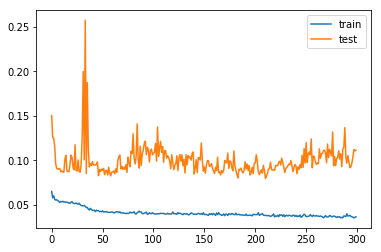

In [102]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.savefig("lstm-training.png")
pyplot.show()


## 8. Prepare input data for prediction

In [297]:
test_data  = dev_count_perday['count'].to_numpy()[1005 - (360 + 205):] # 205 records were not part of training
print(len(test_data))
# ensure all data is float
values = test_data.astype('float32')

# normalize features

scaled = scaler.transform(values.reshape(-1, 1))
print(scaler.data_max_)
print(scaler.data_min_)

# frame as supervised learning
reframed = series_to_supervised(scaled, n_input_seq, 1)
print(reframed.shape)
values = reframed.values

# split into input and outputs
n_obs = n_input_seq * n_features
test_X, test_y = values[:, :n_obs], values[:, n_obs:n_obs+n_features]
print(test_X.shape, len(test_X), test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], n_input_seq, n_features))
print(test_X.shape, test_y.shape)

565
[272.]
[1.]
<class 'numpy.ndarray'>
(205, 361)
(205, 360) 205 (205, 1)
(205, 360, 1) (205, 1)


## 9. Prediction vs. Actual for the unseen data by the model (205 days)

In [298]:
K.clear_session()  # Clear previous models from memory.    
model = load_model("epoch-211_loss-0.0380_val_loss-0.0798.h5")
# make a prediction
yhat = model.predict(test_X)

# invert scaling for forecast
inv_yhat = scaler.inverse_transform(yhat)

# invert scaling for actual
inv_y = scaler.inverse_transform(test_y)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 80.059


default: [24.0, 10.0]


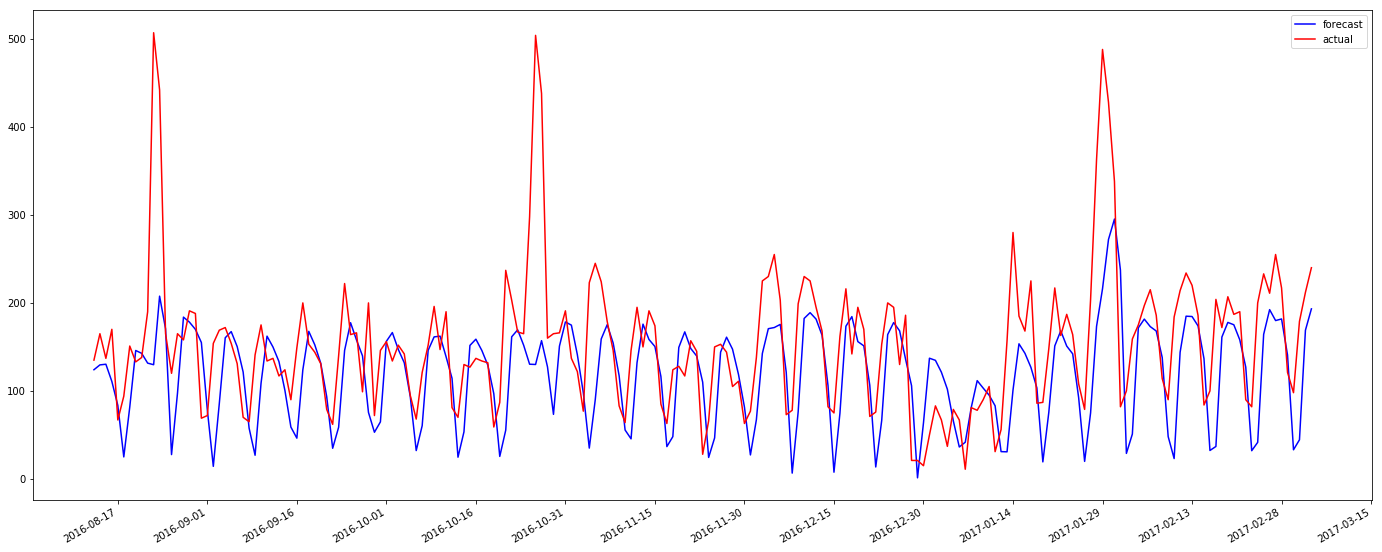

In [293]:
start = pd.Timestamp('2016-08-13')
end = start + timedelta(days=205)
days = mdates.drange(start, end,dt.timedelta(days=1))

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.plot(days, inv_yhat, "-b", label='forecast') # forecast
plt.plot(days, inv_y,    "-r"   , label='actual')   # actual
plt.legend(loc="upper right")
plt.gcf().autofmt_xdate()

fig_size = plt.rcParams["figure.figsize"]
print("default:", fig_size)
fig_size[0] = 24
fig_size[1] = 10
plt.rcParams["figure.figsize"] =  fig_size 

plt.show()